# Исследование интернет-магазина «Подарочек»

Исследование данных онлайн-магазина "Подарочек" с сегментацией клиентов и проверкой статистических гипотез.  
### Цель исследования
Анализ клиентов магазина для формирования рекомендаций бизнесу по взаимодействию с клиентами, определить на каких клиентах фокусироваться и в каких странах необходимо обратить внимание для развития и изменения стратегии развития.
### Задачи и план работы
#### Осмотр и предобработка данных:
1. Проверка пропусков, дубликатов и типов данных, и соответствие идентификаторов;
2. Объединение данных с покупкой и записью;
3. Обработка выбросов и аномальных значений для принятия решения о необходимости сохранить их или нет;
4. Изучение полноты данных для выбора периода для анализа с основными данными.
#### Расчеты и сегментация:
1. Оценка кол-ва заказов по часам и дням недели и уникальных покупателей, для проверки наличия цикличности;
2. Расчет средней выручки с клиента в день и кол-во уникальных покупателей, проверка наличия сезонности;
3. Анализ сезонности и цикличности в течение года;
4. Расчет стики-фактора за 2-ой и 3-ий квартал 2019 года;
5. Составить профиль каждого клиента;
6. Разделить клиентов на возвратных и нет;
7. Разделить клиентов по методике RFM.
#### Формирование рекомендаций и статистические гипотезы:
1. Рекомендации, по работе с разными RFM группами;
2. Сравнение возвратных и невозвратных клиентов;
3. Сравнение средних чеков в разных странах;
4. Проверка первоначальной гипотез;
5. Формирование новых гипотезы после анализа и их проверка.
### Первоначальная гипотеза
1. У магазина нет постоянных клиентов, так как большая зависимость от сезонных факторов (праздников).
### Описание данных
**Основной датасет**
- `entry_date` — дата записи;
- `order_id` — идентификационный номер заказа;
- `customer_id` — идентификационный номер клиента;
- `quantity` — количество;
- `price — цена`;
- `name_clust` — автоматически присвоенная группа записи на основе названия;
- `entry_id` — идентификационный номер записи;
- `country_id` — идентификационный номер страны.  
**Текстовое описание записей**
- `entry_id` — идентификационный номер записи;
- `entry` — запись.

## 1. Загрузка, осмотр и объединение данных
### 1.1 Импорт необходимых библиотек для работы с данными, загрука датасетов и осмотр данных

In [537]:
# Импорт библиотек 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
import scipy.stats as stats
from scipy.stats import ttest_ind

In [538]:
# Функции для анализа:
def lost_data_and_shape(df_orig, df_new):
    """ Расчет кол-ва потерянных данных и их доли.
    
    Функция принимает на вход оригинальный ДФ и новый.
    """
    lost_data = len(df_orig) - len(df_new)
    lost_data_shape = lost_data / len(df_orig)
    return lost_data, lost_data_shape

def grid_boxplot(df, columns, title, xlabel):
    """ Функция отрисовки графика распределения"""
    plt.figure(figsize=(12,4))
    sns.boxplot(data=df, x=columns)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.grid()

In [539]:
# Загружаем датасет в зависимости от среды запуска
try:
    df_raw = pd.read_csv('datasets/gift.csv')
    df_entry_raw = pd.read_csv('datasets/gift_entry.csv', sep=';')
except:
    df_raw = pd.read_csv('https://code.s3.yandex.net/datasets/gift.csv')
    df_entry_raw = pd.read_csv('https://code.s3.yandex.net/python-for-analytics/gift_entry.csv', sep=';')
# Делаем копию датафрейма
df = df_raw.copy()
df_entry = df_entry_raw.copy()

In [540]:
# Общая информация основого датасета
print('Информация об основном датасете')
display(df.info())
# Проверка числовых данных на корректность
display(df.describe())
# Вывод 5-ти случайных строк
display(df.sample(5))

Информация об основном датасете
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356940 entries, 0 to 356939
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   entry_date   356940 non-null  object
 1   order_id     356940 non-null  int64 
 2   customer_id  356940 non-null  int64 
 3   quantity     356940 non-null  int64 
 4   price        356940 non-null  int64 
 5   name_clust   356940 non-null  int64 
 6   entry_id     356940 non-null  int64 
 7   country_id   356940 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 21.8+ MB


None

,order_id,customer_id,quantity,price,name_clust,entry_id,country_id
count,356940.000000,356940.000000,356940.000000,3.569400e+05,356940.000000,356940.000000,356940.000000
mean,26687.651726,3486.883389,10.149599,3.999940e+02,468.617395,1518.046442,26.751818
std,13381.350493,2542.878257,146.794372,5.059181e+03,259.146901,833.753264,4.978016
min,3031.000000,-1.000000,-9600.000000,-1.106206e+06,0.000000,0.000000,0.000000
25%,14834.000000,-1.000000,1.000000,1.250000e+02,242.000000,875.000000,28.000000
50%,27378.000000,3633.000000,3.000000,2.080000e+02,448.000000,1559.000000,28.000000
75%,38512.000000,5627.500000,10.000000,4.130000e+02,702.000000,2223.000000,28.000000
max,48253.000000,7653.000000,80995.000000,1.354133e+06,929.000000,2916.000000,29.000000


,entry_date,order_id,customer_id,quantity,price,name_clust,entry_id,country_id
68941,03/01/2019 16:22,11999,-1,1,1163,38,723,28
58508,15/02/2019 11:31,10703,5039,12,125,479,2807,28
54877,02/08/2019 12:01,10113,3735,10,165,516,2600,28
229679,20/09/2019 12:35,34128,5554,10,125,437,1203,28
271536,23/10/2019 15:09,38971,2869,1,1995,735,1990,28


#### Вывод по осмотру данных на наличие пропусков и соответствие типов и значений:
Основной датасет `gift` содержит 356940 строчек, в полях отсутствуют пропуски, в датасет присутствуют следующиеполяя:
- `entry_date` — дата записи, представлена в типе `objects` заменить на `datetime64[ns]`;
- `order_id` — идентификационный номер заказа представлен в типе `int` значения корректны;
- `customer_id` — идентификационный номер клиента представлен в типе `int`, присутствуют отрицательные значения, следует проверить их количество и принять решение о удалении или преобразовании, так как 25 процентиль также отрицательный, данных явно много;
- `quantity` — количество представлено в типе `int`, присутствует отрицательное значения, проверить и вероятнее всего удалить их;
- `price` — цена представлена в типе `int`, присутствует отрицательное значения, проверить и вероятнее всего удалить их, также аномально высокие данные представлены, которые сильно далеки от 75 процентиля и влияют на большое отличие между средним и медианой;
- `name_clust` — автоматически присвоенная группа записи на основе названия представлен в типе `int`, аномалий и ошибок не выявлено;
- `entry_id` — идентификационный номер записи представлен в типе `int`, аномалий и ошибок не выявлено, проверить на соответствие с датасет `gift_entry`;
- `country_id` — идентификационный номер страны представлен в типе `int`, аномалий и ошибок не ак датафрейм.я `df`, ка. датафрейм..ейм страны.

Необходимо преобразовать тип поля `entry_date` и проверить аномалии и ошибка в полях: `customer_id`, `quantity` и `price`
В дальнейщем датасет `gift` в тексте будет называться `df`, как датафрейм.

In [543]:
# Общая информация датасета с описанием записей
print('Информация о Датасете с описанием записей')
display(df_entry.info())
# Проверка числовых данных на корректность
display(df_entry.describe())
# Вывод 5-ти случайных строк
display(df_entry.sample(5))

Информация о Датасете с описанием записей
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   entry_id  2917 non-null   int64 
 1   entry     2916 non-null   object
dtypes: int64(1), object(1)
memory usage: 45.7+ KB


None

,entry_id
count,2917.000000
mean,1458.000000
std,842.209693
min,0.000000
25%,729.000000
50%,1458.000000
75%,2187.000000
max,2916.000000


,entry_id,entry
2178,2178,подвеска на сумку из фиолетового стекла с кист...
663,663,"СПИСАНО, ПОВРЕЖДЕНИЕ ВОДОЙ"
375,375,НАЙДЕННЫЙ
422,422,Набор из 12 детских цветных мелов
2542,2542,старинная рождественская скатерть


#### Вывод по осмотру данных в датасете с описанием записей на наличие пропусков и соответствие типов и значений:
Датасет `gift_entry` содержит 2917 строчек, пропуски отсутствуют.
- `entry_id` - идентификационный номер записи представлен в типе `int` не содержит ошибок, минимальное и максимальное значение такое же, как в основном датасете, вероятно ошибок нет, но стоит проверить дополнительно;
- `entry` - запись представлена в типе `object`, что соотвутствует текстовому описанию.

Данные представлены качественно, но стоит быть аккуратным с идентификационным номером записи, при объединении.  
Дальше в тексте датасет `gift_entry` будет называться `df_entry`, как датафрейм.

### 1.2 Проверка данных на наличие дубликатов

#### 1.2.1 Преобразование типов данных в `df`

In [549]:
# Проверим, как предоставлены данные с датой
display(df['entry_date'].head(5))

0    12/01/2018 08:26
1    12/01/2018 08:26
2    12/01/2018 08:26
3    12/01/2018 08:26
4    12/01/2018 08:26
Name: entry_date, dtype: object

In [550]:
# Данные представлены в формате Д/М/Г ЧЧ:ММ
df['entry_date'] = pd.to_datetime(df['entry_date'], format='%d/%m/%Y %H:%M')
# Проверим результат и новый тип:
display(df['entry_date'].head(5))
display(df['entry_date'].info())

0   2018-01-12 08:26:00
1   2018-01-12 08:26:00
2   2018-01-12 08:26:00
3   2018-01-12 08:26:00
4   2018-01-12 08:26:00
Name: entry_date, dtype: datetime64[ns]

<class 'pandas.core.series.Series'>
RangeIndex: 356940 entries, 0 to 356939
Series name: entry_date
Non-Null Count   Dtype         
--------------   -----         
356940 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.7 MB


None

#### 1.2.2 Проверкак на наличие дубликатов
1. Проверим на наличие явных дубликатов в обоих датасетах.

In [553]:
# Проверяем количество дубликатов основного датафрейма:
print(f'Дубликатов в датафрейм df: {df.duplicated().sum()}')
duplicated_share = df.duplicated().sum()/len(df)
print(f'Доля дубликатов в датафрейм df: {duplicated_share:.1%}')
# Проверяем количество дубликатов датафрейма с названием записей:
print(f'Дубликатов в датафрейм df: {df_entry.duplicated().sum()}')
duplicated_share = df_entry.duplicated().sum()/len(df_entry)
print(f'Доля дубликатов в датафрейм df: {duplicated_share:.1%}')

Дубликатов в датафрейм df: 3573
Доля дубликатов в датафрейм df: 1.0%
Дубликатов в датафрейм df: 0
Доля дубликатов в датафрейм df: 0.0%


Доля дубликатов в основном датафрейме 1% исключим их для исключения ошибок при анализе.

In [555]:
df.drop_duplicates(keep='first', inplace=True)
# Проверяем количество дубликатов:
print(f'Дубликатов в датафрейм: {df.duplicated().sum()}')

Дубликатов в датафрейм: 0


2. Проверим наличие неявных дубликатов в названиях записей.

In [558]:
df_entry['entry_lower'] = df_entry['entry'].str.lower()
display(df_entry[df_entry.duplicated(subset=['entry_lower'], keep=False)])

,entry_id,entry,entry_lower
757,757,ФОРМА для выпечки шоколадных кексов,форма для выпечки шоколадных кексов
764,764,Форма для выпечки шоколадных кексов,форма для выпечки шоколадных кексов
819,819,"Шкатулка для безделушек Марии-Антуанетты, золотая","шкатулка для безделушек марии-антуанетты, золотая"
2778,2778,форма для выпечки шоколадных кексов,форма для выпечки шоколадных кексов
2869,2869,"шкатулка для безделушек Марии-Антуанетты, золотая","шкатулка для безделушек марии-антуанетты, золотая"


В датафрейме с наименованием записей присутствуют дубликаты со значением id равным 757, 764, 819, 2778, 2869. Удалим последние дубликаты и удалим столбец, который использовали для проверки

In [560]:
df_entry = df_entry.drop_duplicates(subset=['entry_lower'], keep='last')
df_entry = df_entry.drop('entry_lower', axis=1)
display(df_entry.head())
display(len(df_entry))

,entry_id,entry
0,0,NaN
1,1,10-цветная ручка Spaceboy
2,2,"12 карандашей, черепа"
3,3,"12 карандашей, высокий тюбик, лесной массив"
4,4,"12 карандашей, маленький тюбик с черепом"


2914

Неявные дубликаты исключены из датафрейма с названиями записей

#### 1.2.3 Проверка нулевых значений в датафрейме `df_entry`

In [564]:
display(df_entry.query('entry_id == 0'))

,entry_id,entry
0,0,NaN


С id 0 отсутствует наименование позиции, перед объединением проверим количество таких записей

#### 1.2.4 Проверка на соответствие идентификационных номеров и объединение
1. В столбце `customer_id` есть отрицательные значения, проверим их и примем решение по ним:

In [567]:
# Минимальное значение id пользователя
print('Минимальный id до фильтрации:')
display(df['customer_id'].min())
# Посмотрим на минимлаьное значение больше -1:
print('Минимальный id после фильтрации:')
display(df.query('customer_id > 0')['customer_id'].min())

Минимальный id до фильтрации:


-1

Минимальный id после фильтрации:


1713

In [568]:
# Подсчитаем долю таких пользоваетелей:
customer_id_error_shape = df.query('customer_id <= 0')['customer_id'].count() / len(df)
print(f'Доля пользователей с отрицательным и нулевым id в датафрейм df: {customer_id_error_shape:.1%}')

Доля пользователей с отрицательным и нулевым id в датафрейм df: 26.1%


In [569]:
display(df.query('customer_id <= 0'))

,entry_date,order_id,customer_id,quantity,price,name_clust,entry_id,country_id
395,2018-01-12 11:52:00,3080,-1,56,0,0,0,28
912,2018-01-12 14:32:00,3210,-1,2,251,111,1198,28
913,2018-01-12 14:32:00,3210,-1,4,85,193,2882,28
914,2018-01-12 14:32:00,3210,-1,2,166,227,1260,28
915,2018-01-12 14:32:00,3210,-1,9,166,581,2551,28
...,...,...,...,...,...,...,...,...
356660,2019-09-12 10:26:00,48164,-1,1,413,439,44,28
356661,2019-09-12 10:26:00,48164,-1,5,329,388,2649,28
356662,2019-09-12 10:26:00,48164,-1,5,413,427,957,28
356663,2019-09-12 10:26:00,48164,-1,1,1079,103,366,28


Количество записей с отрицательным значением в `customer_id` составляет больше четверти от всех данных, удалять их для анализа значит лишиться большой части данных, а следующее после него минимальное значение начинается с 1713. При анализе продаж по периодам эти данные нам не помешают.  
При анализе поведения клиентов, конверсии, разделении на группы, клиентов без идентификатора удалим, так как они будут считаться ошибкой.

2. Значения `entry_id` проверим что в df не присутствует id, которых нет в df_entry:

In [572]:
# Формируем два списка с уникальными id из двух датафрейм
df_arr = np.sort(df['entry_id'].unique())
df_entry_arr = np.sort(df_entry['entry_id'].unique())
# Проверяем что они одинаковые, а также узнаем сразу полноту данных
answer = np.array_equal(df_arr,df_entry_arr)
print(f'entry_id совпадают в обоих датафрейм: {answer}')

entry_id совпадают в обоих датафрейм: False


`entry_id` совпадают, но есть нулевые значения, проверим их количество перед объединением, так как приведет к наличию пропусков из-за отсутствия названия у нулевого id:

In [574]:
# Подсчитаем долю таких записей:
zero_entry_id_shape = df.query('entry_id == 0')['entry_id'].count() / len(df)
print(f'Доля нулевых order_id в датафрейм df: {zero_entry_id_shape:.1%}')

Доля нулевых order_id в датафрейм df: 0.4%


Доля нулевых значений составляет 0.4 процента, можно их исключить из выборки, чтобы при дальнейшем анализе, например, при анализе популярных позиций мы не столкнулись с неизвестным товаром. Также мы видели ранее, что эти данные имеют нулевую цену, так что они нам будут мешать. Ведь данные должны быть чистыми и без пропусков.

In [576]:
df = df.query('entry_id > 0')
# Подсчитаем долю таких записей:
zero_entry_id_shape = df.query('entry_id == 0')['entry_id'].count() / len(df)
print(f'Доля нулевых order_id в датафрейм df: {zero_entry_id_shape:.1%}')

Доля нулевых order_id в датафрейм df: 0.0%


3. В столбцах `name_clust` и `country_id` есть нулевые значения, проверим их долю от общего количества и решим что делать дальше с ними:

In [578]:
# Подсчитаем долю нулевых country_id:
zero_country_id_shape = df.query('country_id == 0')['country_id'].count() / len(df)
print(f'Доля нулевых country_id в датафрейм df: {zero_country_id_shape:.1%}')
# Подсчитаем долю нулевых name_clust:
zero_name_clust_shape = df.query('name_clust == 0')['name_clust'].count() / len(df)
print(f'Доля нулевых name_clust в датафрейм df: {zero_name_clust_shape:.1%}')

Доля нулевых country_id в датафрейм df: 0.2%
Доля нулевых name_clust в датафрейм df: 0.4%


Доля таких данных невысоках, можно их исключить, так как при статистическом анализе эти данные будут мешать формировать группы по поведению, из-за отсутствия информации.

In [580]:
df = df.query('country_id != 0 & name_clust != 0')
# Подсчитаем долю нулевых country_id:
zero_country_id_shape = df.query('country_id == 0')['country_id'].count() / len(df)
print(f'Доля нулевых country_id в датафрейм df: {zero_country_id_shape:.1%}')
# Подсчитаем долю нулевых name_clust:
zero_name_clust_shape = df.query('name_clust == 0')['name_clust'].count() / len(df)
print(f'Доля нулевых name_clust в датафрейм df: {zero_name_clust_shape:.1%}')

Доля нулевых country_id в датафрейм df: 0.0%
Доля нулевых name_clust в датафрейм df: 0.0%


#### 1.2.5 Объединение датафреймов:

In [582]:
df_full = df.merge(df_entry, on='entry_id', how='left')
# Проверим полноту данных после объединения:
print('Информация об объединенном датафрейме')
display(df_full.info())
# Проверка числовых данных на корректность
display(df_full.describe())
# Вывод 5-ти случайных строк
display(df_full.sample(5))

Информация об объединенном датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349696 entries, 0 to 349695
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   entry_date   349696 non-null  datetime64[ns]
 1   order_id     349696 non-null  int64         
 2   customer_id  349696 non-null  int64         
 3   quantity     349696 non-null  int64         
 4   price        349696 non-null  int64         
 5   name_clust   349696 non-null  int64         
 6   entry_id     349696 non-null  int64         
 7   country_id   349696 non-null  int64         
 8   entry        349538 non-null  object        
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 24.0+ MB


None

,entry_date,order_id,customer_id,quantity,price,name_clust,entry_id,country_id
count,349696,349696.000000,349696.000000,349696.000000,3.496960e+05,349696.000000,349696.000000,349696.000000
mean,2019-06-16 15:59:03.606733312,26703.754352,3493.858792,10.400943,3.304074e+02,472.374102,1527.073232,26.797947
min,2018-01-12 08:26:00,3031.000000,-1.000000,1.000000,0.000000e+00,1.000000,1.000000,1.000000
25%,2019-03-24 10:38:00,14844.000000,-1.000000,1.000000,1.250000e+02,247.000000,900.000000,28.000000
50%,2019-07-04 10:11:00,27395.000000,3640.000000,3.000000,2.080000e+02,450.000000,1562.000000,28.000000
75%,2019-10-05 11:44:00,38516.000000,5633.000000,10.000000,4.130000e+02,705.000000,2223.000000,28.000000
max,2019-12-10 17:19:00,48253.000000,7653.000000,80995.000000,1.354133e+06,929.000000,2916.000000,29.000000
std,NaN,13380.040061,2536.750222,143.053254,2.716342e+03,256.724070,827.882782,4.842955


,entry_date,order_id,customer_id,quantity,price,name_clust,entry_id,country_id,entry
185120,2019-02-08 16:11:00,28779,-1,1,579,241,654,28,"Розы Регентства, чашка и блюдце"
322239,2019-11-25 09:23:00,45353,5297,10,165,70,1388,28,катушка с лентой флора + фауна
247045,2019-07-10 09:38:00,36675,5862,12,208,804,1904,28,набор из 5 блинных магнитов
269073,2019-10-25 13:30:00,39342,3742,12,208,438,1449,28,колокольчик сердце антикварное золото
75210,2019-03-14 11:44:00,13164,4507,6,165,615,1716,28,"маленькая стеклянная форма для мороженого, про..."


In [583]:
lost_data = len(df_raw) - len(df_full)
lost_data_shape = lost_data / len(df_raw)
print(f'Количество потеряных данных: {lost_data}')
print(f'Доля потеряных данных: {lost_data_shape:.1%}')

Количество потеряных данных: 7244
Доля потеряных данных: 2.0%


Два процента потерянных данных, не так страшно, учитывая что они стали более чистыми, дальше разберемся с аномальными значениями и сравним сколько ещё данных будет удаленно или изменено. Из ошибок мы оставили только ``customer_id`` так как их доля от всего датафрейма большая и они повлияют на анализ клиентов, где мы их исключим вероятнее всего

## 2. Предобработка данных и начало исследовательского анализа
Изучим все столбцы на наличие выбросов и аномальных значений, идентификационные номера, рассмотрим полноту данных и выберим период для анализа данных. Период данных содержащий основную часть данных будет использоваться для последующего анализа.

### 2.1 Выброси и аномальные значения в столбцах `quantity` и `price`
#### 2.1.1 Столбец `quantity`
После изучения данных обнаружено, что в столбце `quantity` присутствуют аномально высокие значения, что влияет на среднее значение и мы видим большое отличие межде средним и медианым значением. Изучим аномальные значения и посмотрим на распределение данных.

count    349696.000000
mean         10.400943
std         143.053254
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: quantity, dtype: float64

Количество данных:


349696

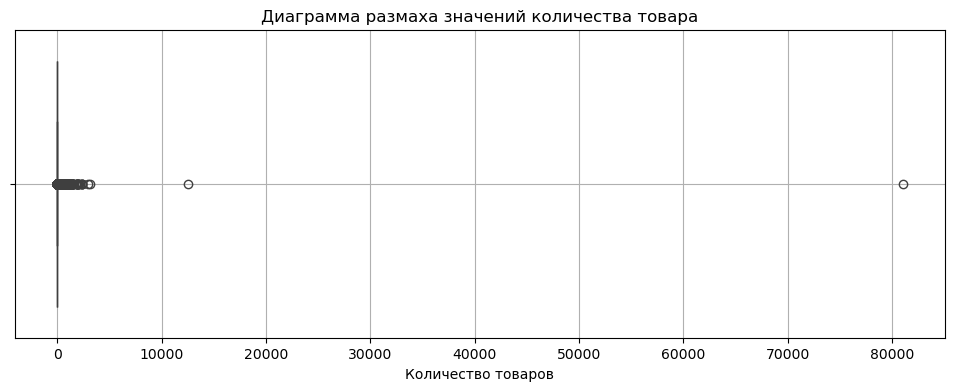

In [588]:
# Сделаем копию полного датафрейма для сравнения в будущем
df_clean = df_full.copy()

display(df_clean['quantity'].describe())
print('Количество данных:')
display(len(df_clean['quantity']))

plt.figure(figsize=(12,4))
sns.boxplot(data=df_clean, x='quantity')

plt.title('Диаграмма размаха значений количества товара')
plt.xlabel('Количество товаров')
plt.grid()
plt.show()

По диаграмме размаха видны выбросы после 10000, до этого плотность данных сохраняется, удалим их из выборки, чтобы не влияли на конечный результат и посмотрим на распределение данных

count    349694.000000
mean         10.133525
std          35.500742
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max        3186.000000
Name: quantity, dtype: float64

Количество данных:


349694

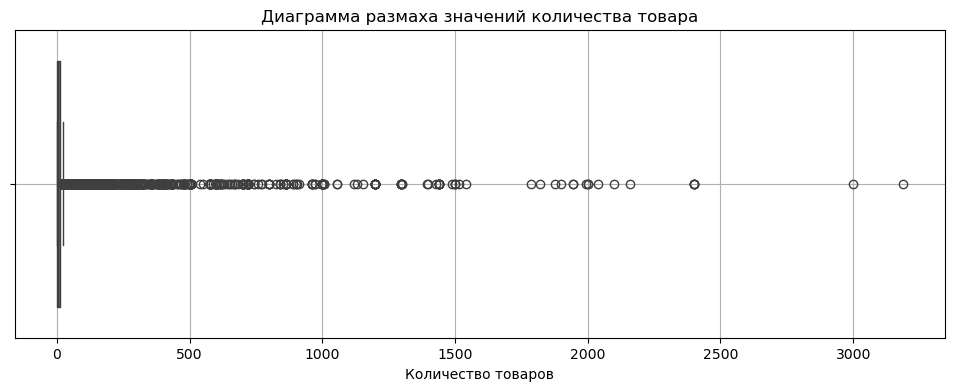

In [590]:
df_clean = df_clean.query('quantity < 10000')
display(df_clean['quantity'].describe())
print('Количество данных:')
display(len(df_clean['quantity']))

plt.figure(figsize=(12,4))
sns.boxplot(data=df_clean, x='quantity')

plt.title('Диаграмма размаха значений количества товара')
plt.xlabel('Количество товаров')
plt.grid()
plt.show()

По новому набору данных также видим большой разброс данных после 1000, так как у магазина есть оптовые клиенты, мы можем бесконечно сокращать выборку, но для интереса сократим до 200 и посмотрим, как изменится среднее значение и сколько данных останется в датафрейме:

count    348295.000000
mean          8.553025
std          15.460839
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max         199.000000
Name: quantity, dtype: float64

Количество данных:


348295

Количество исключенных данных: 1399
Доля исключенных данных: 0.40%


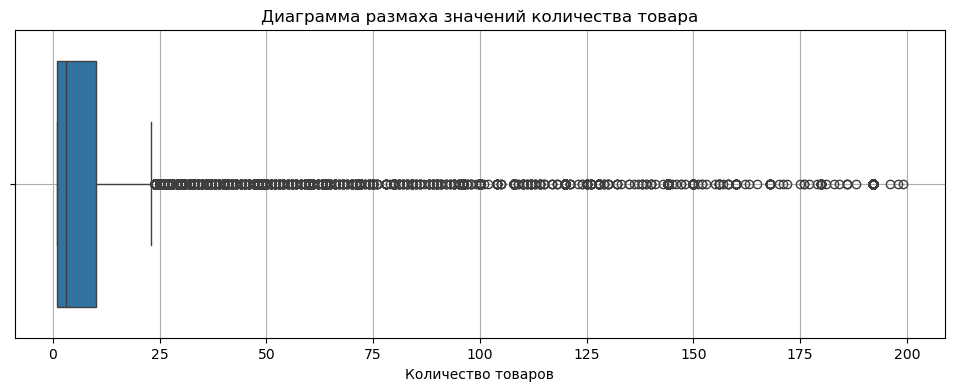

In [592]:
display(df_clean.query('quantity < 200')['quantity'].describe())
print('Количество данных:')
display(len(df_clean.query('quantity < 200')))

lost_data = len(df_clean) - len(df_clean.query('quantity < 200'))
lost_data_shape = lost_data / len(df_clean)
print(f'Количество исключенных данных: {lost_data}')
print(f'Доля исключенных данных: {lost_data_shape:.2%}')

plt.figure(figsize=(12,4))
sns.boxplot(data=df_clean.query('quantity < 200'), x='quantity')

plt.title('Диаграмма размаха значений количества товара')
plt.xlabel('Количество товаров')
plt.grid()
plt.show()

Мы сократили выборку и видим, что все равно есть аномальные значения, но уже  виден "Ящик с усами". Среднее значение сократилось с 143 до 18, , а количество потерянных данных составит 0.4 процента. Можно сделать вывод, что это оптовые клиенты, и у них большие объемы, но даже при выделении оптовых клиентов эти данные бы нам мешали видеть картину целиком. На данном этапе оставим данные до 200 и вернемся к ним при необходимости после анализа клиентов. Так же в первичном анализе мы видели, что 75 процентиль имеет значение 10, что говорит о том, что высоких значений меньше 25 процентов, но исключать все не стоит, лучше потом разделить клиентов.

In [594]:
df_clean = df_clean.query('quantity < 200')

#### 2.1.2 Столбец `price`

После изучения данных обнаружено, что в столбце `price` присутствуют аномально высокие значения, что влияет на среднее значение и мы видим большое отличие межде средним и медианым значением. Изучим аномальные значения и посмотрим на распределение данных в этом столбце с учетом исключенных высоких значений в столбце с количеством:

count    3.482950e+05
mean     3.312134e+02
std      2.721756e+03
min      0.000000e+00
25%      1.250000e+02
50%      2.080000e+02
75%      4.130000e+02
max      1.354133e+06
Name: price, dtype: float64

Количество данных:


348295

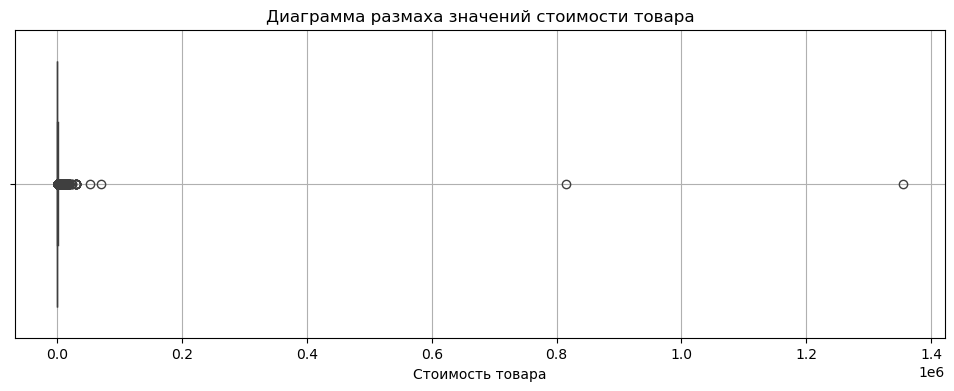

In [597]:
display(df_clean['price'].describe())
print('Количество данных:')
display(len(df_clean['price']))

plt.figure(figsize=(12,4))
sns.boxplot(data=df_clean, x='price')

plt.title('Диаграмма размаха значений стоимости товара')
plt.xlabel('Стоимость товара')
plt.grid()
plt.show()

В датафрейме присутствуют нулевы значений и аномально высокие выбросы, исключим сперва значения выше 0.2е+06 и посмотрим сколько нулевых:

count    348293.000000
mean        324.989494
std         493.573917
min           0.000000
25%         125.000000
50%         208.000000
75%         413.000000
max       70000.000000
Name: price, dtype: float64

Количество данных:


348293

Количество нулевой цены: 305
Доля нулевых цен: 0.1%


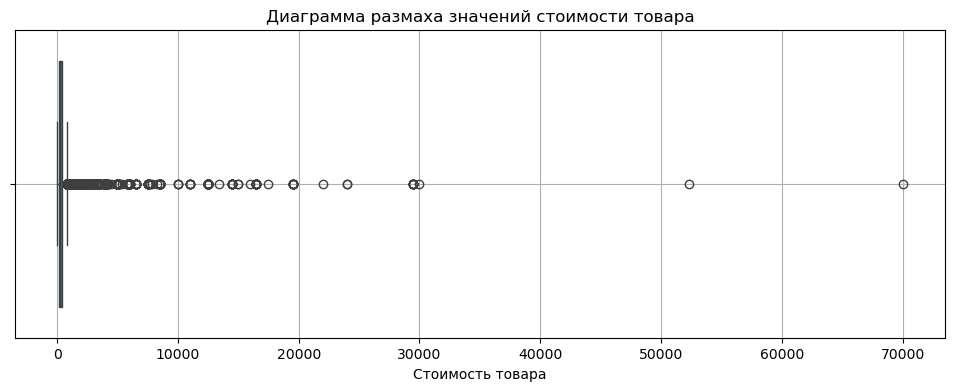

In [599]:
display(df_clean.query('price < 0.2e+06')['price'].describe())
print('Количество данных:')
display(len(df_clean.query('price < 0.2e+06')['price']))

zero_price = len(df_clean.query('price == 0'))
zero_price_shape = zero_price / len(df_clean)
print(f'Количество нулевой цены: {zero_price}')
print(f'Доля нулевых цен: {zero_price_shape:.1%}')

plt.figure(figsize=(12,4))
sns.boxplot(data=df_clean.query('price < 0.2e+06'), x='price')

plt.title('Диаграмма размаха значений стоимости товара')
plt.xlabel('Стоимость товара')
plt.grid()

Доля нулевых значений составляет лишь 0.1 процента, возможно это акция была или ошибка записи, но лучше их исключить из выборки. Также после новой фильтрации мы видим, что более плотно данные распределены в районе до 4000, так что методом исключения подберем оптимальное значение:

count    345703.000000
mean        303.864997
std         300.925768
min           6.000000
25%         125.000000
50%         208.000000
75%         413.000000
max        1996.000000
Name: price, dtype: float64

Количество данных:


345703

Количество исключенных данных: 2592
Доля исключенных данных: 0.7%


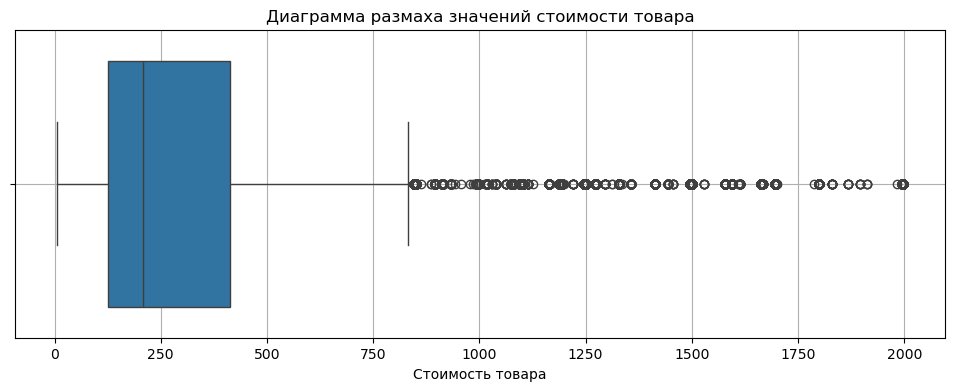

In [601]:
display(df_clean.query('price > 0 & price < 2000')['price'].describe())
print('Количество данных:')
display(len(df_clean.query('price > 0 & price < 2000')['price']))

lost_data = len(df_clean) - len(df_clean.query('price > 0 & price < 2000'))
lost_data_shape = lost_data / len(df_clean)
print(f'Количество исключенных данных: {lost_data}')
print(f'Доля исключенных данных: {lost_data_shape:.1%}')

plt.figure(figsize=(12,4))
sns.boxplot(data=df_clean.query('price > 0 & price < 2000'), x='price')

plt.title('Диаграмма размаха значений стоимости товара')
plt.xlabel('Стоимость товара')
plt.grid()

Методом исключения определили, что пределе в 2000 самый оптимальный, так как мы потеряем только 0.7 процента данных. Дорогие товары нам не интересны, хоть в их стоимость может быть заложена большая маржинальность, что вероятно компенсирует низкую маржинальность более популярных позиций, появляется гипотеза, что дорогие позиции позволяют больше заработать, но для полной картины нас интересует товар, который приносит постоянный доход. По возможности проверим данную гипотезу, что дорогие позиции покрывают расходы лучше товара по средней или низкой цене.

#### 2.1.3 Суммирование общей стоимости товарной позиции
Расчитаем общую стоимость каждой позиции и добавим информацию в столбец `total_price`. Также сравним с данными из полного датафрейма, чтобы увидеть сильно ли изменились данные после исключения дорогих товаров и большого количества.

In [604]:
df_clean['total_price'] = df_clean['quantity'] * df_clean['price']
print('Данные без выборосов и аномальных значений')
display(df_clean['total_price'].describe())
df_full['total_price'] = df_full['quantity'] * df_full['price']
print('Данные c выборосами и аномальных значениями')
display(df_full['total_price'].describe())

Данные без выборосов и аномальных значений


count    3.482950e+05
mean     1.616372e+03
std      4.349777e+03
min      0.000000e+00
25%      3.750000e+02
50%      9.360000e+02
75%      1.700000e+03
max      1.354133e+06
Name: total_price, dtype: float64

Данные c выборосами и аномальных значениями


count    3.496960e+05
mean     1.850831e+03
std      2.922081e+04
min      0.000000e+00
25%      3.750000e+02
50%      9.480000e+02
75%      1.700000e+03
max      1.684696e+07
Name: total_price, dtype: float64

Мы видим, что 25, 50 и 75 прцоентиль никак не изменились, а вот средняя и максимальное значений сильно отличаются, так чт она мой взгляд очистка была полезна. Но высокие значения по итоговой стоимости присутствует, рассмотрим распределение и сделаем вывод так же о их чистке.

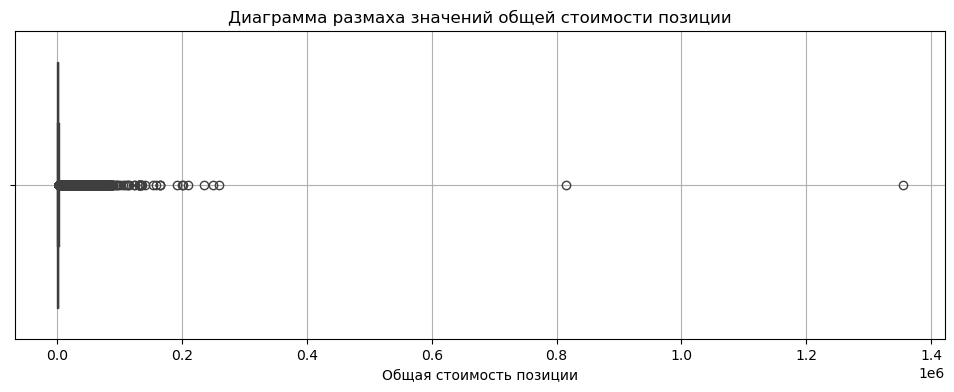

In [606]:
plt.figure(figsize=(12,4))
sns.boxplot(data=df_clean, x='total_price')

plt.title('Диаграмма размаха значений общей стоимости позиции')
plt.xlabel('Общая стоимость позиции')
plt.grid()

Мы видим более менее плотное распределение значений до 100000, методом подбора выберем оптимальное количество данных для исключения:

Количество исключенных данных: 642
Доля исключенных данных: 0.2%


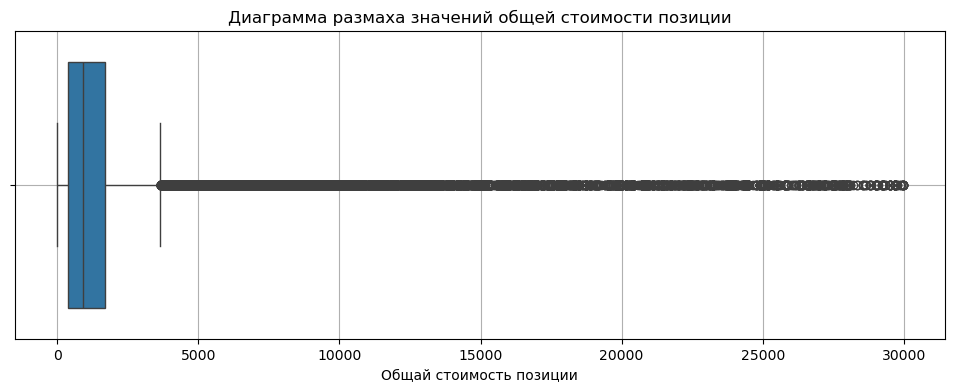

In [608]:
#lost_data = len(df_clean) - len(df_clean.query('price > 0 & price < 2000'))
#lost_data_shape = lost_data / len(df_clean)
lost_data, lost_data_shape = lost_data_and_shape(df_clean, df_clean.query('total_price < 30000'))
print(f'Количество исключенных данных: {lost_data}')
print(f'Доля исключенных данных: {lost_data_shape:.1%}')

grid_boxplot(df_clean.query('total_price < 30000'), 'total_price',
            'Диаграмма размаха значений общей стоимости позиции',
            'Общай стоимость позиции')

В пределах до 30000 начинает плотное распределение значений и количество исключенных данных составит всего 0.2%, исключать все не будем так как у нас есть оптовые клиенты.

In [610]:
df_clean = df_clean.query('total_price < 30000')

### 2.2 Столбцы с идентификаторами
Рассмотрим ещё раз распределение значений с идентификаторами для определения стратегии по анализу их. Сразу выведем краткую информацию о данных и сгруппируем по идентифиакторам, чтобы посмотреть на распределение данных.

In [613]:
display(df_clean[['order_id', 'customer_id', 'name_clust', 'entry_id', 'country_id']].describe())

,order_id,customer_id,name_clust,entry_id,country_id
count,347653.000000,347653.000000,347653.00000,347653.000000,347653.00000
mean,26701.410846,3491.571837,472.64699,1526.894147,26.80402
std,13384.464552,2538.836852,256.72317,828.088270,4.83986
min,3031.000000,-1.000000,1.00000,1.000000,1.00000
25%,14837.000000,-1.000000,247.00000,900.000000,28.00000
50%,27392.000000,3640.000000,450.00000,1562.000000,28.00000
75%,38516.000000,5633.000000,706.00000,2223.000000,28.00000
max,48253.000000,7653.000000,929.00000,2916.000000,29.00000


#### 2.2.1 Столбец `order_id`
Содержит информацию об уникальных идентификаторах заказов, данные распределены равномерно, среднее с медианой не сильно различаются. У каждого заказа несколько записей в таблицу, посмотрим на распределение количества позиций в заказах и выведем топ-20 заказов

Количество уникальных заказов: 18394


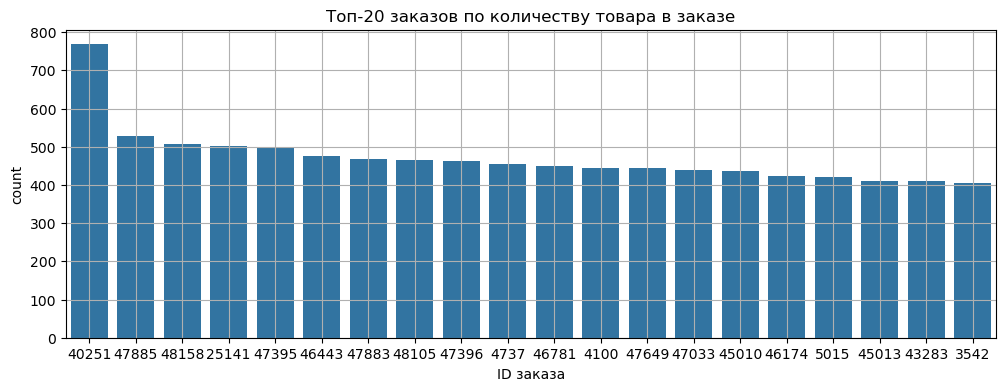

In [616]:
unique_order = df_clean['order_id'].nunique()
print(f'Количество уникальных заказов: {unique_order}')
# Выведем топ-20 заказов
top_categories = df_clean['order_id'].value_counts().nlargest(20)
df_top = df_clean[df_clean['order_id'].isin(top_categories.index)]
plt.figure(figsize=(12,4))
sns.countplot(x='order_id', data=df_clean, order=top_categories.index)
plt.title('Топ-20 заказов по количеству товара в заказе')
plt.xlabel('ID заказа')
plt.grid()

Максимальное количество позиций в одном заказе более 750, остальные топ заказов содержат в пределе 400-500 позиций.

#### 2.2.2 Столбец `customer_id`
Содержит отрицательный значений в большом количестве (ранее мы проверили, что нулевых значений нет), исключить их не можем, так как повлияет сильно на выборку, так что рассмотрим что это за клиенты и какие у них значения в записи:

Из представленой выборки видно, что у всех этих клиентов идентификатор страны одинаковый, а именно 28. Проверим есть ли другие значений стран у этих клиентов. Данный идентификатор присутствует и у других клиентов, так как значение 28 есть в 25, 50 и 75 процентиле. а клиенты -1 только до 25 процентиля встречаются из всей выборки.

In [620]:
display(df_clean.query('customer_id == -1')['country_id'].describe())

count    89609.000000
mean        27.934560
std          1.135074
min          2.000000
25%         28.000000
50%         28.000000
75%         28.000000
max         29.000000
Name: country_id, dtype: float64

Среди них есть клиенты из разных стран и распределение как и в общей выборке. Вероятно это покупатели, которых никак не идентифицируют, а именно розничных покупатели без регистрации в системе магазина и их действия не отслеживают. Стоит учитывать это при сегментации клиентов и расчете стики-факторов. Посмотрим, сколько учтенных клиентов у магазина и как распределяются траты клиентов, без учета тех кого не можем идентифицировать:

Количество уникальных клиентов: 4210


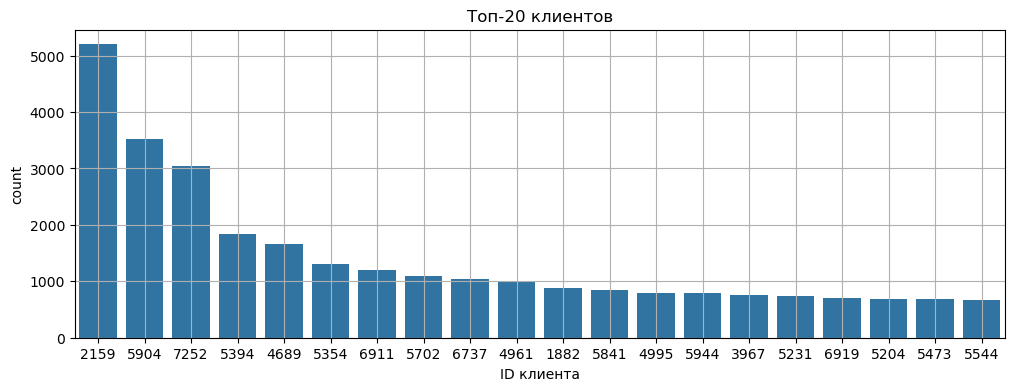

In [622]:
df_with_real_customer = df_clean.query('customer_id != -1')
unique_customer = df_with_real_customer['customer_id'].nunique()
print(f'Количество уникальных клиентов: {unique_customer}')
# Выведем топ-20 клиентов
top_categories = df_with_real_customer['customer_id'].value_counts().nlargest(20)
df_top = df_with_real_customer[df_with_real_customer['customer_id'].isin(top_categories.index)]
plt.figure(figsize=(12,4))
sns.countplot(x='customer_id', data=df_with_real_customer, order=top_categories.index)
plt.title('Топ-20 клиентов')
plt.xlabel('ID клиента')
plt.grid()

Есть клиенты которые приобрели в магазине за весь период более 5000 наименований товаров, но в основном в топе клиенты которые чаще всего посещают магазин приобрели меньше 1000 наименований. Рассмотрим траты клиентов дополнительно

#### 2.2.3 Столбец `name_clust`
Посмотрим на распределение уникальных клиентов в каждой группе:

Количество уникальных групп для записей: 906


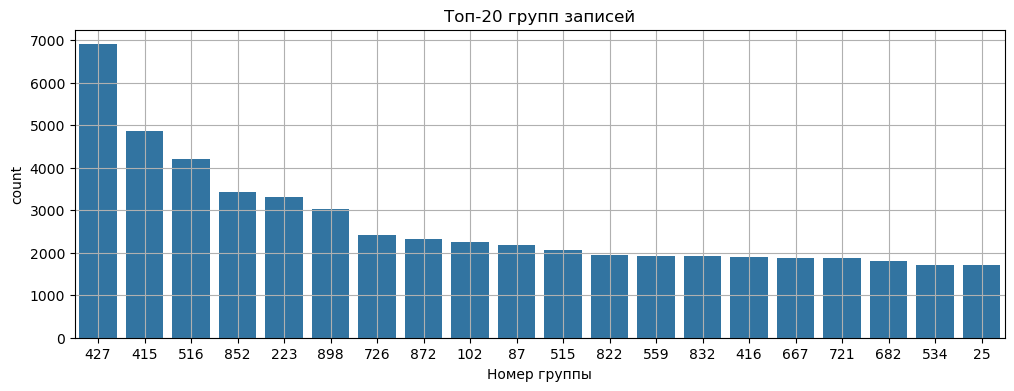

In [625]:
unique_entry = df_clean['name_clust'].nunique()
print(f'Количество уникальных групп для записей: {unique_entry}')
# Выведем топ-20 категорий
top_categories = df_clean['name_clust'].value_counts().nlargest(20)
df_top = df_clean[df_clean['name_clust'].isin(top_categories.index)]
plt.figure(figsize=(12,4))
sns.countplot(x='name_clust', data=df_top, order=top_categories.index)
plt.title('Топ-20 групп записей')
plt.xlabel('Номер группы')
plt.grid()

На столбчатой диаграмме мы видим, какие чаще всего группы автоматически присваивались заказам. Самая популярная группа 427, эта группа была присвоена почти 7000 записям. Всего же уникальных групп в датафрейме содержится 906

#### 2.2.4 Столбец `entry_id`
Посмотрим на распределение записей в датафрейме, чтобы выделить те, которые чаще всего встречаются:

Количество уникальных записей: 2810


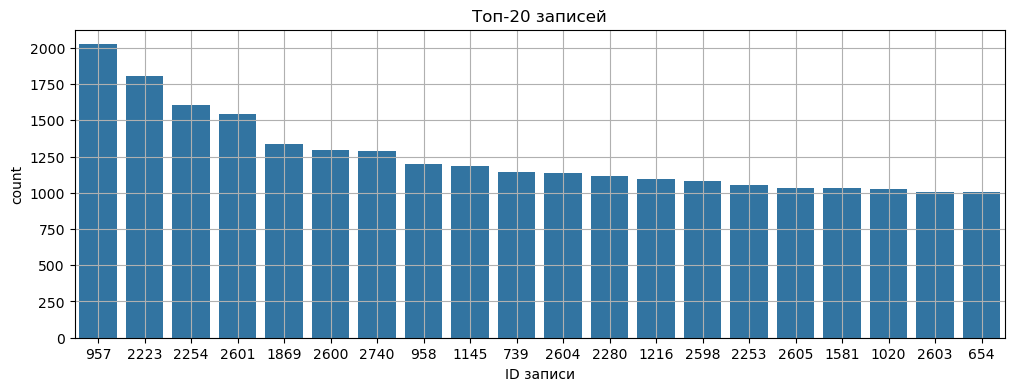

In [628]:
df_group = df_clean.groupby('entry_id').agg({'customer_id': 'count'})
unique_entry = df_clean['entry_id'].nunique()
print(f'Количество уникальных записей: {unique_entry}')
# Выведем топ-20 категорий
top_categories = df_clean['entry_id'].value_counts().nlargest(20)
df_top = df_clean[df_clean['entry_id'].isin(top_categories.index)]
plt.figure(figsize=(12,4))
sns.countplot(x='entry_id', data=df_top, order=top_categories.index)
plt.title('Топ-20 записей')
plt.xlabel('ID записи')
plt.grid()

Из диаграммы мы можем сделать вывод о самых популярных позициях у клиентов, которые встерчались чаще всего, это запись с ID равным 957, он встречается более 2000 раз. остальные позиции можно считать популярными если они встречаются от 1000 раз. Всего в датафрейме содержится 2811 уникальных записей

#### 2.2.5 Столбец `country_id`
Посмотрим на распределение записей в датафрейме, чтобы выделить те, которые чаще всего всречаются и которые приносят больший доход:

In [631]:
df_group = df_clean.groupby('country_id').agg({'customer_id': 'count'}).reset_index()
display(df_group.sort_values('customer_id', ascending=False))

,country_id,customer_id
27,28,323777
5,6,6630
4,5,6211
22,23,1702
2,3,1533
15,16,1528
24,25,1416
18,19,1107
16,17,743
10,11,529


Из первичного осмотра информации о количестве клиентов в каждой стране, можно сделать вывод, что в странах свыше 2000 довольно высокие значения, отобразим их отдельно на графике, как топ-3, остальные страны отобразим интерактивного графика для возможности посмотреть значения.

Количество стран: 29


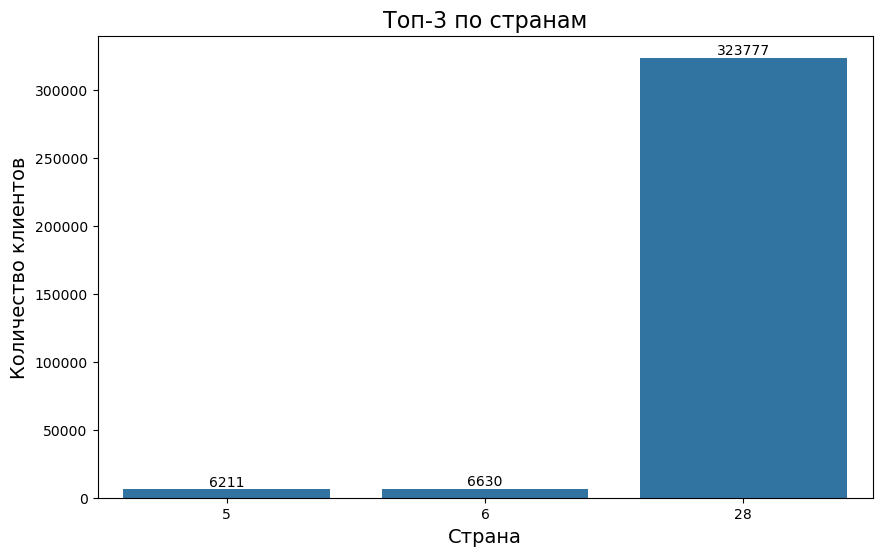

In [633]:
df_group = df_clean.groupby('country_id').agg({'customer_id': 'count'}).reset_index()
unique_country = df_clean['country_id'].nunique()
print(f'Количество стран: {unique_country}')
# Выведем топ-3 стран
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    x='country_id', 
    y='customer_id', 
    data=df_group.query('customer_id > 5000'),
    )

barplot.set_title('Топ-3 по странам', fontsize=16)
barplot.set_xlabel('Страна', fontsize=14)
barplot.set_ylabel('Количество клиентов', fontsize=14)
barplot.bar_label(barplot.containers[0])
plt.show()

In [634]:
fig = px.bar(df_group.query('customer_id < 5000'), x='country_id',
             y='customer_id', text_auto=True,
             title='Страны с меньшим количеством клиентов')
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
    )
)
fig.show() 

Страны в которых больше всего клиентов: 5,  6 и 28, в стране с id=28 аномально высокое количество клиентов, и занимают общую часть всего датафрейма. Клиентов из страны 28 лучше рассматривать отдельно при изучении разных рынков сбыта, так как это основные клиенты. Группы 5 и 6 также выделяются из остальных групп и при сравнении по поведению пользователей в разных странах лучше брать значения, где клиентов менее 2000.

### 2.3 Полнота данных по времени записей
Посчитаем по месяцам количество дней в которых не было продаж и выберем период для анализа содержащий основную часть данных.

Период начала сбора данных: 2018-01-12 08:26:00
Период окончания сбора данных: 2019-12-10 17:19:00


,day_without_order
entry_date,
2018-01-31,19
2018-02-28,27
2018-03-31,30
2018-04-30,30
2018-05-31,30
2018-06-30,29
2018-07-31,30
2018-08-31,30
2018-09-30,29


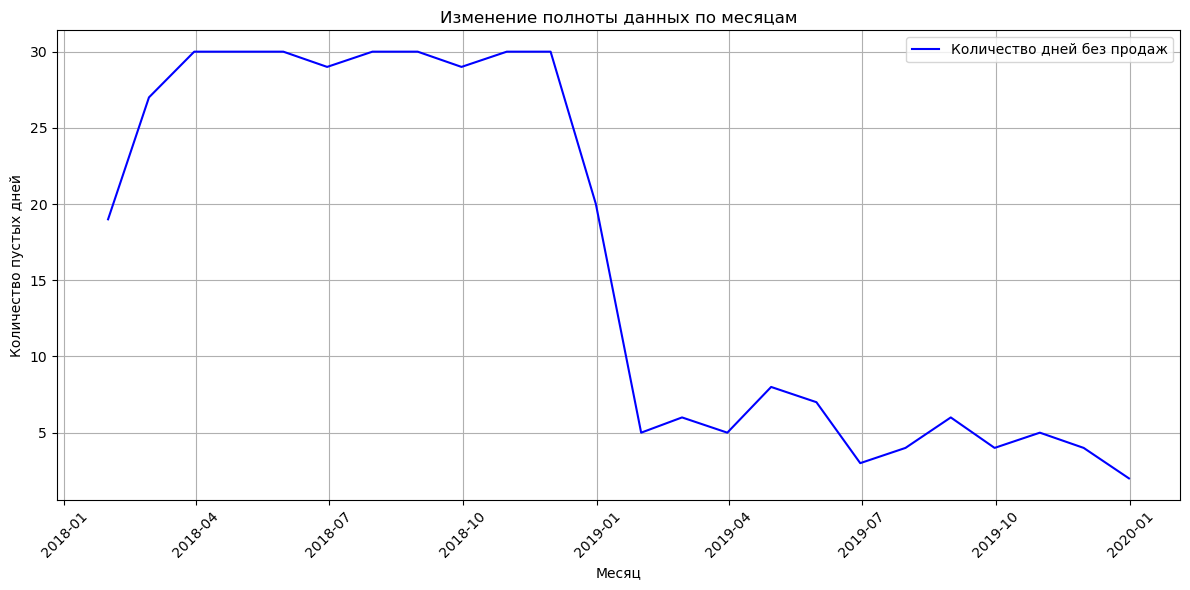

In [637]:
df_month = df_clean.copy()
min_date = df_month['entry_date'].min()
max_date = df_month['entry_date'].max()
print(f'Период начала сбора данных: {min_date}')
print(f'Период окончания сбора данных: {max_date}')
df_month = df_month.set_index('entry_date')
# Создаем датафрейм где будут дни с нулевым количеством уникальных заказов в день
df_zero_day_res = df_month.resample('D').agg({'order_id': 'nunique'}).query('order_id == 0')
# Создаем датафрейм, где укажем количество нулевых значений в месяце
df_month_zero_day_res = df_zero_day_res.resample('ME').agg(day_without_order=('order_id', 'count'))

display(df_month_zero_day_res)

plt.figure(figsize=(12, 6))
plt.plot(df_month_zero_day_res.index, df_month_zero_day_res['day_without_order'],
         label='Количество дней без продаж', color='blue')
plt.title('Изменение полноты данных по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество пустых дней')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show() 

По линейному графику видно, что в 2019 году количество дней без продаж сократилось в 5-6 раз, и больше не увеличивалось, а значит период подходящий для анализа начинается это с января по ноябрь 2019 года включительно. За декабрь у нас есть данные только за 10 дней и два из них без продаж, так что его не будем включать по следующим причинам, это не предоставит данные полностью за месяц и это он очень подвержен сезонности (покупка новогодних подарков), а значит будет выбиваться из общего представления о клиентах и выручке.. Просмотрим, как выглядит график с данными где количество дней без заказов меньше 10:

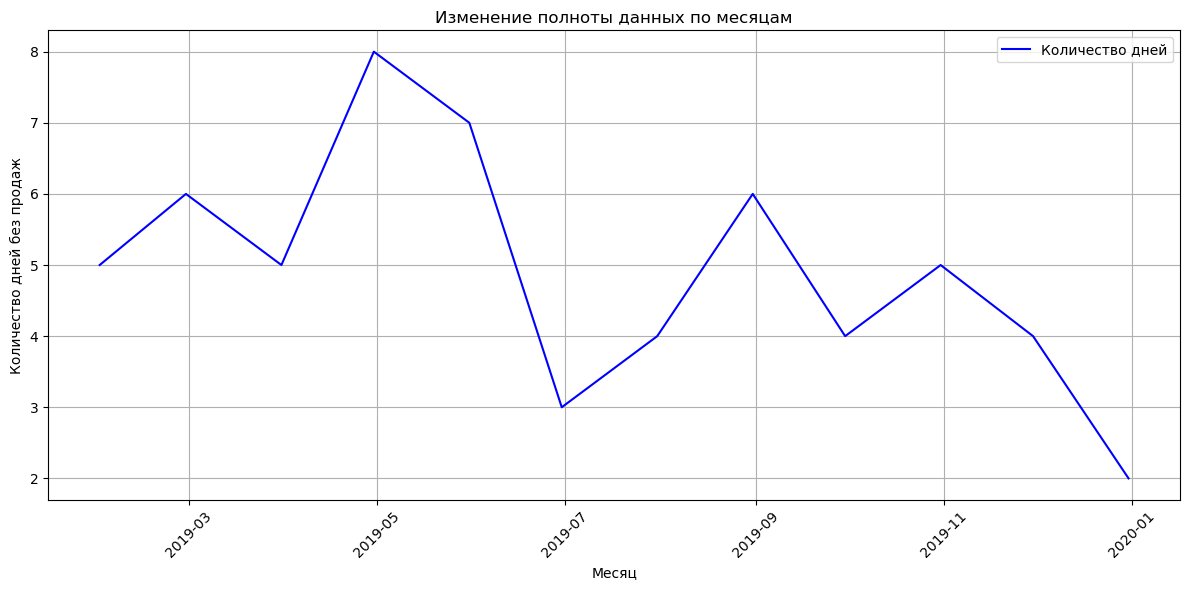

In [639]:
# Отфильтруем датафрейм с количеством нулевых дней в месяц меньше десяти
df_month_min_zero_day = df_month_zero_day_res.query('day_without_order < 10')

plt.figure(figsize=(12, 6))
plt.plot(df_month_min_zero_day.index, df_month_min_zero_day['day_without_order'],
         label='Количество дней', color='blue')
plt.title('Изменение полноты данных по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество дней без продаж')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show() 

In [640]:
# Фильтруем датафрейм по дате, оставляем только данные начинающиеся с февраля:
df_actual = df_clean.query('entry_date > "2019-01-01 00:00:00" & entry_date < "2019-12-01 00:00:00"')
lost_data, lost_data_shape = lost_data_and_shape(df_clean, df_actual)
print(f'Количество исключенных данных: {lost_data}')
print(f'Доля исключенных данных: {lost_data_shape:.1%}')

Количество исключенных данных: 34772
Доля исключенных данных: 10.0%


#### Вывод по предобработке данных.
Мы убрали из датафрейма не полные данные, тем самым обеспечили себе репрезентативные данные, по которым можно проводить анализ, потери составили 10% данных.  
Также по анализу идентификаторов мы выяснили, что большая часть клиентов находится в одной стране, есть клиенты с очень высокими тратами, и есть позиции которые приносят больше всего дохода.

### 3. Расчёт метрик
Так как нам придется проводить расчет уникальных пользователей, предлагаю исключить из выборки клиентов с -1, хоть они составляют большую долю данных порядка 24%, но так мы сможем провести корректно расчеты

#### 3.1 Расчет метрик по часам и дням недели.
Оценим распределение количества заказов и уникальных клиентов по часам и дням недели. Посмотрим на наличие или отсутствие закономерности времени и дня недели на количество заказов и клиентов. Наличие этих килентов может привести к занижению числа уникальных клиентов.

In [645]:
lost_data, lost_data_shape = lost_data_and_shape(df_actual, df_actual.query('customer_id != -1'))
print(f'Количество потерянных данных: {lost_data}')
print(f'Доля потерянных данных: {lost_data_shape:.1%}')
df_actual_2 = df_actual.query('customer_id != -1')

Количество потерянных данных: 77145
Доля потерянных данных: 24.7%


In [646]:
# Сделаем копию датафрейма с индексом времени
df_time = df_actual_2.set_index('entry_date')
df_hour_order = (df_time.resample('h')
                 .agg({'order_id': 'nunique','customer_id': 'nunique'}))
df_hour_order = (df_hour_order
                 .groupby(df_hour_order.index.hour)
                 .agg({'order_id': 'mean','customer_id': 'mean'})
                 .reset_index()
                 .query('entry_date > 4 & entry_date < 22'))
display(df_hour_order)
days_map = {
    0: 'Понедельник',
    1: 'Вторник',
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}
df_day_order = df_time.resample('D').agg({'order_id': 'nunique',
                                          'customer_id': 'nunique'})
df_day_week_order = (df_day_order
                     .groupby(df_day_order.index.weekday)
                     .agg({'order_id': 'mean','customer_id': 'mean'})
                     .reset_index())
df_day_week_order['entry_date'] = df_day_week_order['entry_date'].replace(days_map)
display(df_day_week_order)

,entry_date,order_id,customer_id
5,5,0.000000,0.000000
6,6,0.003012,0.003012
7,7,0.063253,0.060241
8,8,1.378378,1.300300
9,9,3.414414,3.183183
10,10,5.429429,5.123123
11,11,5.672673,5.300300
12,12,7.888889,7.411411
13,13,6.639640,6.249249
14,14,5.768769,5.393393


,entry_date,order_id,customer_id
0,Понедельник,48.787234,45.297872
1,Вторник,17.680851,16.000000
2,Среда,43.791667,40.645833
3,Четверг,46.812500,43.375000
4,Пятница,54.458333,50.666667
5,Суббота,49.500000,45.729167
6,Воскресенье,62.063830,57.659574


In [647]:
# График по часам
fig = px.line(df_hour_order, x='entry_date',
              y=['order_id', 'customer_id'],
              title='Среднее количество заказов и клиентов в час')
fig.show() 
# График по дням недели
fig = px.line(df_day_week_order, x='entry_date',
              y=['order_id', 'customer_id'],
              title='Среднее количество заказов и клиентов по дням недели')
fig.show() 

В течение дня в среднем количество клиентов больше всего в 12 часов дня, самые активные часы покупок это период с 10 утра до 15 часов дня.  
В течении недели покупательская активность растет со среды по понедельник, во вторник меньше всего клиентов и заказов. Так же виден разрыв между количеством заказов и коилчеством уникальных клиентов, что свидетельствует о наличии постоянных клиентов.

#### 3.2 Расчет средней выручки с клиента в день и количество уникальных клиентов.
Рассчитаем среднюю выручку по месяцам с одного клиента в день и количество уникальных покупателей.

In [650]:
month_names = {
    1: 'Январь', 2: 'Февраль', 3: 'Март', 4: 'Апрель', 5: 'Май',
    6: 'Июнь', 7: 'Июль', 8: 'Август', 9: 'Сентябрь', 
    10: 'Октябрь', 11: 'Ноябрь', 12: 'Декабрь'
}
df_monthly = (df_actual_2.groupby(df_actual_2['entry_date'].dt.month)
              .agg(uniq_customer=('customer_id', 'nunique'),
                   total_revenue=('total_price', 'sum'),
                   days_in_month=('entry_date', lambda x: x.dt.date.nunique()))
             .reset_index())
df_monthly['avg_revenue'] = df_monthly['total_revenue'] / df_monthly['days_in_month'] / df_monthly['uniq_customer']
df_monthly['entry_date'] = df_monthly['entry_date'].map(month_names)
display(df_monthly)

,entry_date,uniq_customer,total_revenue,days_in_month,avg_revenue
0,Январь,835,29086538,26,1339.776048
1,Февраль,771,26523171,22,1563.681818
2,Март,908,30812009,26,1305.151178
3,Апрель,856,30620799,22,1625.998248
4,Май,968,35580412,24,1531.525999
5,Июнь,995,35291131,27,1313.647162
6,Июль,1025,36253892,27,1309.987064
7,Август,922,33350678,25,1446.884078
8,Сентябрь,1147,44870677,26,1504.616625
9,Октябрь,1202,45450037,26,1454.308108


In [651]:
# График средней выручки на клиента в день по месяцам
fig1 = px.line(df_monthly, x='entry_date', y='avg_revenue',
               title='Средняя выручка с клиента в месяц',
               labels={'entry_date': 'Месяц', 'avg_revenue': 'Средняя выручка (руб)'})
fig1.show()

# График количества уникальных покупателей по месяцам
fig2 = px.line(df_monthly, x='entry_date', y='uniq_customer',
               title='Количество уникальных покупателей по месяцам',
               labels={'entry_date': 'Месяц', 'uniq_customer': 'Количество уникальных покупателей'})
fig2.show()


На графике средней выручки с клиента в месяц видна сезонная активность, перед праздниками повышение выручки и значение во время отпускного периода. По Количеству уникальных клиентов можно наблюдать их рост, возможно магазин провел акцию или купил рекламу, но в месяцы, когда были больише значения средней выручки с клиента в день, можно сделать вывод что количество уникальных клиентов меньше, а значит это постоянные клиенты.

#### 3.3 Расчет стики-фактора за второй и третий квартал 2019 года

In [654]:
df_quarter = df_actual_2[df_actual_2['entry_date'].dt.quarter.isin([2,3])]

daily_customers = (df_quarter
                   .groupby(df_quarter['entry_date'].dt.date)
                   .agg(uniq_customers=('customer_id', 'nunique')))
avg_daily_customers = daily_customers['uniq_customers'].mean()
print(f'Среднее количество уникальных пользователей в день: {avg_daily_customers}')

monthly_customers = (df_quarter
                   .groupby(df_quarter['entry_date'].dt.month)
                   .agg(uniq_customers=('customer_id', 'nunique')))
avg_monthly_customers = monthly_customers['uniq_customers'].mean()
print(f'Среднее количество уникальных пользователей в месяц: {avg_monthly_customers}')

sticky_factor = avg_daily_customers / avg_monthly_customers
print(f'Стики-фактор за 2 и 3 квартал 2019 года: {sticky_factor:.2%}')

Среднее количество уникальных пользователей в день: 50.788079470198674
Среднее количество уникальных пользователей в месяц: 985.5
Стики-фактор за 2 и 3 квартал 2019 года: 5.15%


Стики фактор довольно низкий, значит большая часть клиентов у магазина это не постоянные клиенты. Гипотеза, которая была озвучена изначально о том, что магазин не имеет постоянных клиентов подветрждена.

#### 3.4 Составление профиля пользователя
Составим профиль пользователя, где будет информация о его первой и последней покупке, общей сумме заказов, средняя цена заказа, страна, насколько разнообразные товары приобретает (кол-во уникальных позиций в заказах), возвратный клиент или нет (1 - да, 0 - нет).

In [657]:
profiles_customers = (df_actual_2.groupby('customer_id')
                      .agg(first_order=('entry_date', 'min'),
                           last_order=('entry_date', 'max'),
                           country_id=('country_id', 'first'),
                           total_purchase=('total_price', 'sum'),
                           nunique_order=('entry_id', 'nunique'),
                           count_orders=('order_id', 'nunique')))
profiles_customers['first_order'] = profiles_customers['first_order'].dt.date
profiles_customers['last_order'] = profiles_customers['last_order'].dt.date
profiles_customers['mean_price_order'] = profiles_customers['total_purchase'] / profiles_customers['count_orders']
profiles_customers['return_customer'] = np.where(profiles_customers['count_orders'] > 1, 1, 0)
profiles_customers['order_recency'] = (pd.to_datetime('2020-01-01') -
                                       pd.to_datetime(profiles_customers['last_order'])).dt.days
display(profiles_customers.describe())
display(profiles_customers.head())

,country_id,total_purchase,nunique_order,count_orders,mean_price_order,return_customer,order_recency
count,4059.000000,4.059000e+03,4059.000000,4059.000000,4059.000000,4059.000000,4059.000000
mean,26.499138,9.892147e+04,40.934467,3.789111,23837.072761,0.631436,121.996551
std,5.399486,2.806494e+05,54.220100,5.920940,22979.506310,0.482475,90.461055
min,1.000000,2.900000e+02,1.000000,1.000000,290.000000,0.000000,32.000000
25%,28.000000,1.884300e+04,11.000000,1.000000,11465.875000,0.000000,47.000000
50%,28.000000,4.144200e+04,24.000000,2.000000,18675.000000,1.000000,88.000000
75%,28.000000,1.000120e+05,52.000000,4.000000,28987.700000,1.000000,179.000000
max,29.000000,1.218799e+07,1118.000000,162.000000,375346.000000,1.000000,364.000000


,first_order,last_order,country_id,total_purchase,nunique_order,count_orders,mean_price_order,return_customer,order_recency
customer_id,,,,,,,,,
1713,2019-05-22,2019-10-28,28,61114,25,2,30557.000000,1,65
1717,2019-01-23,2019-11-30,28,148035,200,14,10573.928571,1,32
1718,2019-02-12,2019-05-08,28,11886,8,2,5943.000000,1,238
1720,2019-07-03,2019-07-03,28,13290,7,1,13290.000000,0,182
1722,2019-09-27,2019-09-27,28,12690,6,1,12690.000000,0,96


Расчитаем для каждой группы средние показатели, основываясь на данных из профиля пользователя:

In [659]:
group_profile = (profiles_customers.reset_index()
                    .groupby('return_customer')
                    .agg({'total_purchase': ['mean', 'median'],
                         'nunique_order': ['mean', 'median'],
                         'mean_price_order': ['mean', 'median'],
                         'customer_id': 'count'}))
display(group_profile)

total_purchase          nunique_order        mean_price_order  \
                          mean   median          mean median             mean   
return_customer                                                                 
0                  23323.03008  16582.0     15.471257   11.0     23323.030080   
1                 143047.60359  73655.0     55.797113   38.0     24137.114841   

                         customer_id  
                  median       count  
return_customer                       
0                16582.0        1496  
1                19700.0        2563

In [660]:
print('Общие показатели возвратных клиентов')
display(profiles_customers.query('return_customer == 1')[
        ['total_purchase', 'nunique_order', 'count_orders', 'mean_price_order']
        ].describe())
print('Общие показатели невозвратных клиентов')
display(profiles_customers.query('return_customer == 0')[
        ['total_purchase', 'nunique_order', 'mean_price_order']
        ].describe())

Общие показатели возвратных клиентов


,total_purchase,nunique_order,count_orders,mean_price_order
count,2.563000e+03,2563.000000,2563.000000,2563.000000
mean,1.430476e+05,55.797113,5.417089,24137.114841
std,3.449938e+05,62.471053,6.952306,19645.253558
min,1.342000e+03,1.000000,2.000000,366.500000
25%,3.950050e+04,20.000000,2.000000,12631.000000
50%,7.365500e+04,38.000000,4.000000,19700.000000
75%,1.495470e+05,71.000000,6.000000,29609.000000
max,1.218799e+07,1118.000000,162.000000,265907.083333


Общие показатели невозвратных клиентов


,total_purchase,nunique_order,mean_price_order
count,1496.000000,1496.000000,1496.000000
mean,23323.030080,15.471257,23323.030080
std,27776.751557,16.256941,27776.751557
min,290.000000,1.000000,290.000000
25%,9523.000000,6.000000,9523.000000
50%,16582.000000,11.000000,16582.000000
75%,27523.000000,19.000000,27523.000000
max,375346.000000,179.000000,375346.000000


Смущает, что среди возвратных клиентов очень высокое значение количества заказов, посмотрим распределение данных:

count    2563.000000
mean        5.417089
std         6.952306
min         2.000000
25%         2.000000
50%         4.000000
75%         6.000000
max       162.000000
Name: count_orders, dtype: float64

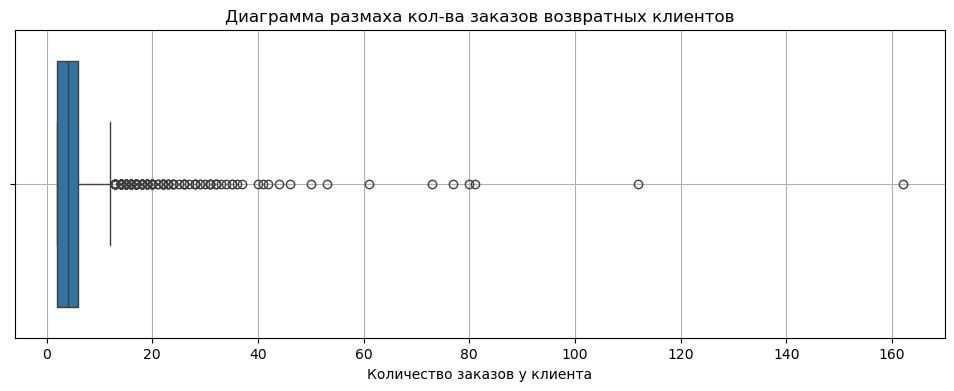

In [662]:
grid_boxplot(profiles_customers.query('return_customer == 1'), 'count_orders',
             'Диаграмма размаха кол-ва заказов возвратных клиентов',
             'Количество заказов у клиента')
display(profiles_customers.query('return_customer == 1')['count_orders'].describe())

#### Вывод по группам возвратных и невозвратных клиентов
Вовзратные клиенты в среднем обеспечили выручку в 4-5 раз больше чем невозвратные клиенты, заказы у них содержат больше разных позиций, средний чек покупок у разных групп не сильно отличается.  
Возвратные клиенты в среднем возвращаются в магазин в течении 11 месяцев 4 раза, если судить по графику уникальных посетителей, то он просядает в сезонную активность, а значит эти клиенты чаще возвращаются к нам перед праздниками. Можно выбрать стратегию по привлечению постоянных покупателей и в другие дни, а для невозвратных принять стратегию привлечения в предпраздничные периоды.

### 4. RFM-сегментация клиентов
Проведем разделение клиентов на группы по методике RFM для отображения полной картины о клиентах и формулирвоании рекомендаций. Для расчета частоты покупки товаров возьмем границы основываясь на диаграмму размаха кол-ва заказов у возвратных клиентов, чтобы количество лояльных клиентов не было завышено за счет аномальных значений.

In [665]:
rfm = profiles_customers.reset_index()[['customer_id', 'order_recency', 'count_orders', 'total_purchase']]

rfm['r'] = pd.qcut(rfm['order_recency'], q=3, labels=[3,2,1])
rfm['f'] = pd.cut(rfm['count_orders'], [0, 2, 10, 163], labels=[1,2,3])
rfm['m'] = pd.qcut(rfm['total_purchase'], q=3, labels=[1,2,3])
rfm[['r','f','m']] = rfm[['r','f','m']].astype('str')
rfm['rfm_group'] = rfm['r'] + rfm['f'] + rfm['m'] 
rfm[['r','f','m']] = rfm[['r','f','m']].astype('int')
rfm['rfm_sum'] = rfm[['r','f','m']].sum(axis=1)
display(rfm.head())

,customer_id,order_recency,count_orders,total_purchase,r,f,m,rfm_group,rfm_sum
0,1713,65,2,61114,2,1,2,212,5
1,1717,32,14,148035,3,3,3,333,9
2,1718,238,2,11886,1,1,1,111,3
3,1720,182,1,13290,1,1,1,111,3
4,1722,96,1,12690,2,1,1,211,4


Сгруппируем пользователей по группам:

In [667]:
rfm_group = rfm.groupby('rfm_group').agg({'customer_id':'nunique',
                                          'rfm_sum':'mean'}).reset_index()
display(rfm_group.sort_values(by='customer_id', ascending=False)) 
fig = px.treemap(rfm_group, 
                 path=['rfm_group'],
                 values='customer_id',
                 color='rfm_sum',
                 color_continuous_scale='Sunset',
                 title='RFM сегментация пользователей онлайн-магазина "Подарочек"')

# Отобразим график:
fig.show() 

,rfm_group,customer_id,rfm_sum
0,111,711,3.0
19,323,497,8.0
1,112,366,4.0
12,223,364,7.0
7,211,356,4.0
8,212,303,5.0
18,322,220,7.0
14,311,216,5.0
21,333,204,9.0
11,222,198,6.0


#### Вывод по RFM сегментации клиентов:
- Сегмент 111 - увеличить частоту покупок и средний чек, а именно напоминать о себе клиентам, чтобы вернуть их.  
- Сегменты 323, 223 - предпринять действия по удержанию клиентов и увеличению числа покупок, так как есть потенциал получения выручки в этих - группах.  
- Сегменты 112, 211, 212 - увеличить число покупок, что может стимулировать рост выручки от них и повторное возвращение.  
- Сегменты 322, 311, 222 - принять действия по сохранению клентов, например предложить скидку на следующую покупку.  
- Сегмент 333 - идеальные клиенты для бизнеса, предложить индивидуальные услуги для сохрания и привлечения других клиентов.  
- Сегменты 123, 122, 113, 121, 133 - клиенты покупали достаточно давно, но доходность и частота на среднем уровне. Стратегия — реактивация: возвращающие письма, акции, промокоды.  
- Сегменты 312, 213, 221 - нужно увеличить частоту покупок. Стратегия — акции и скидки за регулярность покупок.  
- Сегменты 233, 332 - необходимо предпринять действия по удержанию: программы лояльности, индивидуальное обслуживание.

### 5. Статистические гипотезы

#### 5.1 Сравнение долей возвратных и невозвратных клиентов
Сравним доли возвратных и невозвратных клиентов за второй и третий квартал 2019 года. Сформулируем гипотезы:
- Нулевая гипотеза (H₀): Доли возвратных клиентов во втором и третьем квартале 2019 года одинаковы.
- Альтернативная гипотеза (H₁): Доли возвратных клиентов во втором и третьем квартале 2019 года различны.

In [671]:
# Создаем датафрейм с вернувшимися клиентами во 2-м квартале
df_2q = df_actual_2[df_actual_2['entry_date'].dt.quarter.isin([2])]
df_2q = df_2q.groupby('customer_id').agg(count_orders=('order_id', 'nunique'))
all_customers_2q = len(df_2q)
return_cutomers_2q = len(df_2q.query('count_orders > 1'))

# Создаем датафрейм с вернувшимися клиентами в 3-м квартале
df_3q = df_actual_2[df_actual_2['entry_date'].dt.quarter.isin([3])]
df_3q = df_3q.groupby('customer_id').agg(count_orders=('order_id', 'nunique'))
all_customers_3q = len(df_3q)
return_cutomers_3q = len(df_3q.query('count_orders > 1'))

returned_customers = [return_cutomers_2q, return_cutomers_3q]
all_customers = [all_customers_2q, all_customers_3q]

alpha = 0.05

z_stat, p_value = proportions_ztest(count=returned_customers,
                                    nobs=all_customers)

print(f'Z-статистика: {z_stat:.4f}')
print(f'P-значение: {p_value:.4f}')

# Вывод по результатам теста
alpha = 0.05
if p_value < alpha:
    print("Отклоняем нулевую гипотезу, доли возвратных клиентов различны.")
else:
    print("Не можем отклонить нулевую гипотезу, доли возвратных клиентов одинаковы.")

Z-статистика: -0.6976
P-значение: 0.4854
Не можем отклонить нулевую гипотезу, доли возвратных клиентов одинаковы.


Высокое значение p-value = 0.4854 говорит о том, что доля возвратных клиентов в двух кварталах не отличаются.

#### 5.2 Сравнение средних чеков в разных странах
Сравним средние чеки клиентов с country_id равным 3, 6 и 12. Тестирование будет проводиться с помощью t-тестирования и ANOVA.  
Сформируем гипотезы для каждой пары:
- Нулевая гипотеза (H₀): Средние чеки в странах одинаковы.
- Альтернативная гипотеза (H₁): Средние чеки в странах различаются.  


In [674]:
def user_country_group(df, country_id):
    """Функция для группировки пользователей по стране.

    Функция вовзращает датафрейм с средним чеком каждого
    клиента в стране с указанным country_id.
    """
    df = df.query('country_id == @country_id')
    df = df.groupby(['customer_id', 'order_id']).agg({'total_price': 'sum'}).reset_index()
    df = df.groupby('customer_id').agg(mean_purchase=('total_price', 'mean'))
    return df

In [675]:
# Создаем датафреймы с данными по каждой стране
df_country_3 = user_country_group(df_actual_2, 3)['mean_purchase']
print(f'Объем данных в стране 3: {len(df_country_3)}')
df_country_6 = user_country_group(df_actual_2, 6)['mean_purchase']
print(f'Объем данных в стране 6: {len(df_country_6)}')
df_country_12 = user_country_group(df_actual_2, 12)['mean_purchase']
print(f'Объем данных в стране 12: {len(df_country_12)}')

t_stat_3_6, p_value_3_6 = stats.ttest_ind(df_country_3, df_country_6, equal_var=False)
t_stat_3_24, p_value_3_24 = stats.ttest_ind(df_country_3, df_country_12, equal_var=False)
t_stat_6_24, p_value_6_24 = stats.ttest_ind(df_country_6, df_country_12, equal_var=False)

p_values = [p_value_3_6, p_value_3_24, p_value_6_24]
alpha = 0.5

#reject, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='bonferroni')

pairs = ['3 и 6', '3 и 24', '6 и 24']
for i, p_value in enumerate(p_values):
    print(f'Сравнение {pairs[i]}:')
    print(f'P-значение: {p_value}')
    if p_value < alpha:
        print(f'Отклоняем нулевую гипотезу, средние чеки в странах {pairs[i]} различаются.')
    else:
        print(f'Не можем отклонить нулевую гипотезу, средние чеки в странах {pairs[i]} не различаются.')

Объем данных в стране 3: 25
Объем данных в стране 6: 92
Объем данных в стране 12: 8
Сравнение 3 и 6:
P-значение: 0.8780458548400676
Не можем отклонить нулевую гипотезу, средние чеки в странах 3 и 6 не различаются.
Сравнение 3 и 24:
P-значение: 0.6371489441458831
Не можем отклонить нулевую гипотезу, средние чеки в странах 3 и 24 не различаются.
Сравнение 6 и 24:
P-значение: 0.6539353366957967
Не можем отклонить нулевую гипотезу, средние чеки в странах 6 и 24 не различаются.


Как мы видим результаты показвают, что различий нет, но и выборка данных сильно отличается в каждой стране. Проведем ещё один тест ANOVA с дополнительной проверкой на гомогенность дисперсий и нормальное распределение данных

In [677]:
f_stat, p_value = stats.f_oneway(df_country_3, df_country_6, df_country_12)
alpha = 0.05

print(f'F-статистика: {f_stat:.4f}')
print(f'P-значение: {p_value:.4f}')

if p_value < alpha:
    print("Отклоняем нулевую гипотезу, средние чеки в этих странах различаются.")
else:
    print("Не можем отклонить нулевую гипотезу, средние чеки в этих странах не различаются.")

F-статистика: 0.7226
P-значение: 0.4876
Не можем отклонить нулевую гипотезу, средние чеки в этих странах не различаются.


In [678]:
from scipy.stats import levene

# Проверка гомогенности дисперсий
stat, p = levene(df_country_3, df_country_6, df_country_12)

print(f'Tест Левена: p-значение = {p:.4f}')
if p < 0.05:
    print("Дисперсии не равны (гомогенность нарушена), может понадобиться альтернативный тест.")
else:
    print("Дисперсии равны, можно продолжать с ANOVA.")

Tест Левена: p-значение = 0.0390
Дисперсии не равны (гомогенность нарушена), может понадобиться альтернативный тест.


In [679]:
from scipy.stats import kruskal

# Проведение теста Краскала-Уоллиса
h_stat, p_value_kruskal = kruskal(df_country_3, df_country_6, df_country_12)

print(f'H-статистика: {h_stat:.4f}')
print(f'P-значение: {p_value_kruskal:.4f}')

if p_value_kruskal < alpha:
    print("Отклоняем нулевую гипотезу, средние чеки в этих странах различаются.")
else:
    print("Не можем отклонить нулевую гипотезу, средние чеки в этих странах не различаются.")


H-статистика: 2.8415
P-значение: 0.2415
Не можем отклонить нулевую гипотезу, средние чеки в этих странах не различаются.


После проведения нескольких статистических тестов получилось выяснить, что разницы между средними чеками в странах 3, 6, 12 нет.

### 6. Общий вывод
Магазину необходимо выстроить стратегию на удержание клиентов и увеличение частоту покупок, так как средний чек довольно высокий у клиентов с наименьшим количеством заказов, тем самым можно стимулировать клиентов возвращаться чаще и приобретать подарки не только в сезонные активности. Также не следует отказываться от развития рынка в разных странах, так как средние чеки не различаются, а доход можно увеличить. 

Рекомендация: ввести удобную и привлекательную программу лояльности для более точного сбора информации, так как при анализе было утеряно большое количество данных о клиентах, а также для возвращения клиентов в магазин, так как многие совершают покупки и больше не возвращаются в магазин.

### 7. Дополнительное исследование
Исследование, какие товары чаще всего покупают вместе.  
Цель: выявить на заказах клиентов, что предлагать другим дополнительно для повышения чека.

In [683]:
from itertools import combinations
from collections import Counter

df_order_group = df_actual_2.groupby('order_id')['entry'].apply(list)

pair_counter = Counter()

for products in df_order_group:
    if len(products) > 1:
        pairs = combinations(products, 2)
        pair_counter.update(pairs)

pair_df = pd.DataFrame(pair_counter.items(), columns=['pair', 'frequency'])

pair_df = pair_df.sort_values(by='frequency', ascending=False)

print('5 Самых популярных комбинаций к покупке:')
for pair in pair_df['pair'].head(5):
    print(f'"{pair[0]}" покупают вместе с "{pair[1]}"')

5 Самых популярных комбинаций к покупке:
"сумка для обеда красная Retrospot" покупают вместе с "сумка для обеда в розовый горошек"
"большая сумка розового цвета в горошек" покупают вместе с "большая сумка красного цвета Retrospot"
"сумка для обеда красная Retrospot" покупают вместе с "сумка для обеда дизайн Суки"
"Розы Регентства, чашка и блюдце" покупают вместе с "Зеленая чашка и блюдце в стиле регентства"
"сумка для обеда машинки синяя" покупают вместе с "сумка для обеда в розовый горошек"
